# Download dataset with Pytorch



## Load the data

In [146]:
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from PIL import Image


# Define transformation for each image
transform  = transforms.Compose([
    transforms.Lambda(lambda x: np.array(x).flatten()) #Stretch image into row [32,32,3] -> [3072]
])

# Download a CIFAR10 dataset
dataset = datasets.CIFAR10("content",
                           train=True,
                           transform = transform,
                           download=True)


Files already downloaded and verified


## Split dataset & define dataloaders

torch.Size([256, 3072]) torch.Size([256])


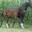

7

In [147]:
train_ds, val_ds, _= random_split(dataset, [20000,1000 ,29000])
# Hint: Perform debug on smaller subset

batch_size = 256

train_loader = DataLoader(train_ds, batch_size = batch_size)
val_loader = DataLoader(val_ds, batch_size = batch_size)

# Display one image
for images, class_nums in train_loader:
  print (images.shape,class_nums.shape) # class_nums are tensor!
  display(Image.fromarray(images[0].reshape((32,32,3)).numpy()),class_nums[0].item()) 
  break 

# Implement LinearClassifier class for CIFAR10

In [148]:
class LinearClassifier:
  def __init__(self, labels):
    self.classes_num = len(labels)
    # Generate a random weight matrix of small numbers
    # You can change this code
    self.W = np.random.randn(3073, self.classes_num) * 0.0001 
    self.batch_size = 200
    self.delta = 1

  
  def train(self, x_batch, y_batch, learning_rate = 1e-8):
    """
      Arguments:
        x  (numpy.array): collection of objects (batch)
        y  (numpy.array): collection of integer 
        representing a class number for objects from x
    
    """
    # Добавляем столбец единиц - вектор сдвига для bias trick и вычисляем потери
    x_batch = self.add_column(x_batch)
    loss, grad = self.loss(x_batch, y_batch)

    # Update weights (self.W)
    self.W -= learning_rate*grad

    return loss

  def loss(self,x, y): # x and y are batches
    """
      Arguments:
        x  (numpy.array): collection of objects (batch)
        y  (numpy.array): collection of integer 
        representing a class number for objects from x
    
    """
    # Calculate Multiclass SVM or Cross-entropy loss over a batch 
 
    dW = np.zeros(self.W.shape)
    num_classes = self.W.shape[1]
    num_train = x.shape[0]
    loss = float(0)

    # Без циклов рассчитываем скоры
    scores = np.dot(x, self.W)
    correct_class_score = scores[range(num_train), y]
    corrects = np.reshape(correct_class_score, (num_train,1))

    # Рассчитываем погрешность, вычитая из скора истинное значение
    margin_with_delta = scores - corrects + self.delta
    margin = np.maximum(0, margin_with_delta)
    margin[range(num_train), y] = 0

    # Суммируем все потери
    loss = np.sum(margin)

    margin[margin > 0] = 1
    # Вычисляем градиент
    dW = margin
    above_zero_loss_counts = np.sum(dW, axis = 1)
    dW[range(len(scores)), y] = -above_zero_loss_counts
    dW = np.dot(x.T, dW)
    dW /= num_train
    loss /= num_train 

    return loss, dW
  
  def add_column(self, x):
    ones = np.ones((x.shape[0], 1))
    return np.concatenate([x, ones], axis = 1)
      
  def predict(self,x):
    x = self.add_column(x)
    scores = x.dot(self.W) # (256, 3073) * (3073, 10)
    return np.argmax(scores,axis = 1)


# Train model

## Function for accuracy checking

Don't change this code

In [149]:
from sklearn.metrics import accuracy_score

def validate(model,dataloader):
  y_predicted = np.array([])
  y_gtrue = np.array([])
  for images, class_nums in dataloader:
    index = model.predict(images.numpy())
    y_predicted = np.append(y_predicted,index) 
    y_gtrue = np.append(y_gtrue,class_nums.numpy()) 
  return accuracy_score(y_gtrue, y_predicted)  

## Train loop
Let's train our model

In [150]:

model = LinearClassifier(dataset.classes)
best_accuracy = 0
for epoch in range(25):
  for images, class_nums in train_loader:
    loss = model.train(images.numpy(), class_nums.numpy())
    accuracy = validate(model,val_loader)
  if best_accuracy < accuracy:
     best_accuracy = accuracy
  print(f"Epoch {epoch} Loss: {loss}, Accuracy:{accuracy}")

print(f"Best accuracy is {best_accuracy}")

Epoch 0 Loss: 6.681699702447195, Accuracy:0.193
Epoch 1 Loss: 5.893872601338211, Accuracy:0.232
Epoch 2 Loss: 5.567627542346191, Accuracy:0.253
Epoch 3 Loss: 5.3471563743512105, Accuracy:0.281
Epoch 4 Loss: 5.184649258886965, Accuracy:0.297
Epoch 5 Loss: 5.056805630561719, Accuracy:0.306
Epoch 6 Loss: 4.9571335086657875, Accuracy:0.305
Epoch 7 Loss: 4.844302695870614, Accuracy:0.31
Epoch 8 Loss: 4.744067487273801, Accuracy:0.313
Epoch 9 Loss: 4.670456118802124, Accuracy:0.316
Epoch 10 Loss: 4.604322973199979, Accuracy:0.324
Epoch 11 Loss: 4.538860793863951, Accuracy:0.327
Epoch 12 Loss: 4.477185559795432, Accuracy:0.327
Epoch 13 Loss: 4.412798280025623, Accuracy:0.331
Epoch 14 Loss: 4.348513968833593, Accuracy:0.33
Epoch 15 Loss: 4.296747861037495, Accuracy:0.332
Epoch 16 Loss: 4.244650433309793, Accuracy:0.335
Epoch 17 Loss: 4.203649084271848, Accuracy:0.335
Epoch 18 Loss: 4.170173648553889, Accuracy:0.337
Epoch 19 Loss: 4.130373756908447, Accuracy:0.337
Epoch 20 Loss: 4.0881035981533

# Check model on test dataset

You must get accuracy above 0.35


In [151]:
test_dataset = datasets.CIFAR10("content",
                           train=False,
                           transform = transform, # Transforms stay the same
                           download=True)

test_loader = DataLoader(test_dataset, batch_size = batch_size)

accuracy = validate(model,test_loader)
print(f"Accuracy on test:{accuracy}")


Files already downloaded and verified
Accuracy on test:0.3449


# Place for brief conclusion
В коде из презентации нужно было поправить несколько измерений


...



# Ideas for extra work

- Implenment CrossEntropyLoss function -
- Implement bias trick +
- Add regularization to SVM loss +
- Find best learning rate and regularization strength using Cross-Validation +-
- Normalize data +


 

In [152]:
mean_image = np.mean(images.numpy(), axis = 0)

In [153]:
from sklearn.base import BaseEstimator
class LinearClassifierEnhanced(BaseEstimator):
  def __init__(self, delta = 1, reg = 1e-5, learning_rate = 1e-8):
    # Generate a random weight matrix of small numbers
    # You can change this code
    self.classes_num = 10
    self.W = np.random.randn(3073, self.classes_num) * 0.0001 
    self.batch_size = 200
    self.delta = delta
    self.reg = reg
    self.learning_rate = learning_rate
    self.loss_ = 0
  
  def fit(self, x_batch, y_batch):
    """
      Arguments:
        x  (numpy.array): collection of objects (batch)
        y  (numpy.array): collection of integer 
        representing a class number for objects from x
    
    """
    # Нормализация данных - вычитаем среднее
    x_batch = x_batch.astype(float)
    x_batch -= mean_image

    # Добавляем столбец единиц - вектор сдвига для bias trick и вычисляем потери
    x_batch = self.add_column(x_batch)
    loss, grad = self.loss(x_batch, y_batch)

    # Update weights (self.W)
    self.W -= self.learning_rate*grad

    self.loss_ = loss
    return self

  def loss(self,x, y): # x and y are batches
    """
      Arguments:
        x  (numpy.array): collection of objects (batch)
        y  (numpy.array): collection of integer 
        representing a class number for objects from x
    
    """
    # Calculate Multiclass SVM or Cross-entropy loss over a batch 
 
    dW = np.zeros(self.W.shape)
    num_classes = self.W.shape[1]
    num_train = x.shape[0]
    loss = float(0)

    # Без циклов рассчитываем скоры
    scores = np.dot(x, self.W)
    correct_class_score = scores[range(num_train), y]
    corrects = np.reshape(correct_class_score, (num_train,1))

    # Рассчитываем погрешность, вычитая из скора истинное значение
    margin_with_delta = scores - corrects + self.delta
    margin = np.maximum(0, margin_with_delta)
    margin[range(num_train), y] = 0

    # Суммируем все потери
    loss = np.sum(margin)

    margin[margin > 0] = 1
    # Вычисляем градиент
    dW = margin
    above_zero_loss_counts = np.sum(dW, axis = 1)
    dW[range(len(scores)), y] = -above_zero_loss_counts
    dW = np.dot(x.T, dW)
    dW /= num_train
    loss /= num_train 
    #регуляризация
    loss += self.reg * np.sum((self.W[:len(self.W)-1] )**2)
    dW += 2 * self.reg * self.W

    return loss, dW
  
  def add_column(self, x):
    ones = np.ones((x.shape[0], 1))
    return np.concatenate([x, ones], axis = 1)
      
  def predict(self,x):
    # Нормализация данных - вычитаем среднее
    x = x.astype(float)
    x -= mean_image
    x = self.add_column(x)
    scores = x.dot(self.W) # (256, 3073) * (3073, 10)
    return np.argmax(scores,axis = 1)

In [154]:
model = LinearClassifierEnhanced()
best_accuracy = 0

for epoch in range(25):
  for images, class_nums in train_loader:
    loss = model.fit(images.numpy(), class_nums.numpy())
    accuracy = validate(model,val_loader)
  if best_accuracy < accuracy:
     best_accuracy = accuracy
  print(f"Epoch {epoch} Loss: {loss.loss_}, Accuracy:{accuracy}")

print(f"Best accuracy is {best_accuracy}")

Epoch 0 Loss: 6.982404611983381, Accuracy:0.241
Epoch 1 Loss: 6.325092998487999, Accuracy:0.276
Epoch 2 Loss: 5.967625185842375, Accuracy:0.297
Epoch 3 Loss: 5.7194166408571805, Accuracy:0.299
Epoch 4 Loss: 5.538913893461691, Accuracy:0.305
Epoch 5 Loss: 5.376127878811101, Accuracy:0.311
Epoch 6 Loss: 5.241360195988338, Accuracy:0.32
Epoch 7 Loss: 5.127690104120857, Accuracy:0.321
Epoch 8 Loss: 5.029891076096693, Accuracy:0.322
Epoch 9 Loss: 4.939622282691353, Accuracy:0.325
Epoch 10 Loss: 4.85867864396845, Accuracy:0.331
Epoch 11 Loss: 4.783613436113044, Accuracy:0.337
Epoch 12 Loss: 4.713627706375143, Accuracy:0.335
Epoch 13 Loss: 4.649670756248232, Accuracy:0.334
Epoch 14 Loss: 4.58573641619015, Accuracy:0.333
Epoch 15 Loss: 4.53087860110482, Accuracy:0.335
Epoch 16 Loss: 4.481326480287317, Accuracy:0.333
Epoch 17 Loss: 4.430770768091279, Accuracy:0.332
Epoch 18 Loss: 4.383072769862976, Accuracy:0.335
Epoch 19 Loss: 4.339279383032541, Accuracy:0.333
Epoch 20 Loss: 4.300353713994732,

In [155]:
test_dataset = datasets.CIFAR10("content",
                           train=False,
                           transform = transform, # Transforms stay the same
                           download=True)

test_loader = DataLoader(test_dataset, batch_size = batch_size)

accuracy = validate(model,test_loader)
print(f"Accuracy on test:{accuracy}")


Files already downloaded and verified
Accuracy on test:0.3626


Модель с регуляризацией и нормализацией действительно работает несколько лучше

In [156]:
from sklearn.model_selection import GridSearchCV

params = [{'delta': [0, 0.5, 1, 1.5, 2],
         'reg': [1e-7, 1e-5, 1e-3, 1e-1],
         'learning_rate': [1e-9, 1e-7, 1e-5, 1e-3, 1e-1]}]

gs = GridSearchCV(LinearClassifierEnhanced(),
                      param_grid=params,
                      scoring='accuracy',
                      cv=5)

gs.fit(images.numpy(), class_nums.numpy())

GridSearchCV(cv=5, estimator=LinearClassifierEnhanced(),
             param_grid=[{'delta': [0, 0.5, 1, 1.5, 2],
                          'learning_rate': [1e-09, 1e-07, 1e-05, 0.001, 0.1],
                          'reg': [1e-07, 1e-05, 0.001, 0.1]}],
             scoring='accuracy')

In [157]:
gs.best_params_

{'delta': 2, 'learning_rate': 1e-07, 'reg': 0.001}

In [159]:
model1 = LinearClassifierEnhanced(2, 0.001, 1e-07)
best_accuracy1 = 0
accuracies1 = []

for epoch in range(25):
  for images, class_nums in train_loader:
    loss = model1.fit(images.numpy(), class_nums.numpy())
    accuracy = validate(model1,val_loader)
    accuracies1.append(accuracy)
  if best_accuracy1 < accuracy:
     best_accuracy1 = accuracy
  #print(f"Epoch {epoch} Loss: {loss.loss_}, Accuracy:{accuracy}")

print(f"Best accuracy is {best_accuracy1}")

Best accuracy is 0.365


In [160]:
model2 = LinearClassifierEnhanced(2, 0.001, 1e-05)
best_accuracy2 = 0
accuracies2 = []

for epoch in range(25):
  for images, class_nums in train_loader:
    loss = model2.fit(images.numpy(), class_nums.numpy())
    accuracy = validate(model2,val_loader)
    accuracies2.append(accuracy)
  if best_accuracy2 < accuracy:
     best_accuracy2 = accuracy
  #print(f"Epoch {epoch} Loss: {loss.loss_}, Accuracy:{accuracy}")

print(f"Best accuracy is {best_accuracy2}")

Best accuracy is 0.315


In [161]:
model3 = LinearClassifierEnhanced(2, 0.001, 1e-09)
best_accuracy3 = 0
accuracies3 = []

for epoch in range(25):
  for images, class_nums in train_loader:
    loss = model3.fit(images.numpy(), class_nums.numpy())
    accuracy = validate(model3,val_loader)
    accuracies3.append(accuracy)
  if best_accuracy3 < accuracy:
     best_accuracy3 = accuracy
  #print(f"Epoch {epoch} Loss: {loss.loss_}, Accuracy:{accuracy}")

print(f"Best accuracy is {best_accuracy3}")

Best accuracy is 0.257


In [162]:
model4 = LinearClassifierEnhanced(1, 0.001, 1e-07)
best_accuracy4 = 0
accuracies4 = []

for epoch in range(25):
  for images, class_nums in train_loader:
    loss = model4.fit(images.numpy(), class_nums.numpy())
    accuracy = validate(model4,val_loader)
    accuracies4.append(accuracy)
  if best_accuracy4 < accuracy:
     best_accuracy4 = accuracy
  #print(f"Epoch {epoch} Loss: {loss.loss_}, Accuracy:{accuracy}")

print(f"Best accuracy is {best_accuracy4}")

Best accuracy is 0.365


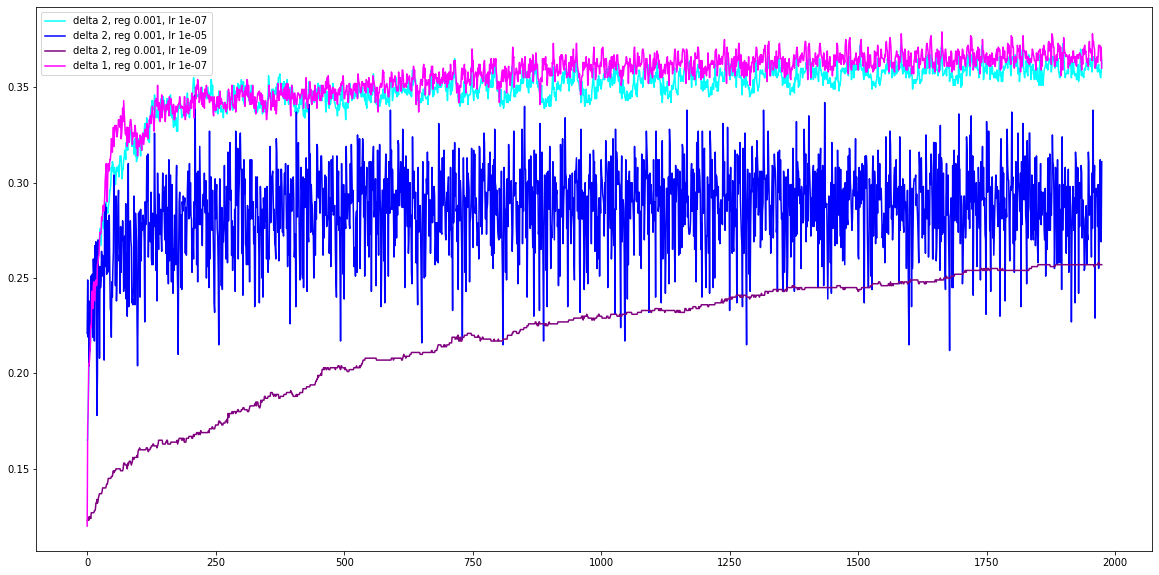

In [163]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(accuracies1, label='delta 2, reg 0.001, lr 1e-07', color = 'cyan')
plt.plot(accuracies2, label='delta 2, reg 0.001, lr 1e-05', color = 'blue')
plt.plot(accuracies3, label='delta 2, reg 0.001, lr 1e-09', color = 'purple')
plt.plot(accuracies4, label='delta 1, reg 0.001, lr 1e-07', color = 'magenta')
plt.legend()
plt.show()

Grid Search оказался довольно странным. Возможно, дело в том, что он считает accuracy только после одного трейна, а не после 25, но в целом его было довольно тяжело прикрепить к нестандартной модели. Можно предположить по графику, что наилучшие (из трех нарисованных моделей) параметры - delta = 1, regularization = 0.001, learning rate = 1e-07. Так как у трех моделей отличается только learning rate, можно предположить, что чем он больше - тем лучше, однако это предположение надо делать крайне осторожно - если он слишком большой, возможно переобучение. 